In [1]:
import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections

from collections import OrderedDict
import uproot
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2


# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [4]:
fpath_bkg =OrderedDict()
tree_bkg = OrderedDict()
tree_sig = OrderedDict()
fpath_sig =OrderedDict()
# path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/V1p15/MC_Summer16/v3/v4/normalized/'
# bkg_path = path+"/bkg/wH/normalized/"
path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p15/MC_Summer16/v3/v3/ggH_HToSSTobbbb_MH-125_TuneCUETP8M1_13TeV-powheg-pythia8/'
# fpath_bkg['bbbb1'] = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/signal.root'
fpath_bkg['ctau100'] = path + 'ggH_HToSSTobbbb_MH-125_TuneCUETP8M1_13TeV-powheg-pythia8_Job0_of_158_55_100.root'
fpath_bkg['ctau1000'] = path + 'ggH_HToSSTobbbb_MH-125_TuneCUETP8M1_13TeV-powheg-pythia8_Job0_of_158_55_1000.root'
fpath_bkg['ctau10000'] = path + 'ggH_HToSSTobbbb_MH-125_TuneCUETP8M1_13TeV-powheg-pythia8_Job0_of_158_55_10000.root'

NEvents = {}

for k,v in fpath_bkg.items():
    print (k, v)
#     tree[k] = rtnp.root2array(v)
    root_dir = uproot.open(v) 
#     if k[:7] == 'ntuples':
#     tree_bkg[k] = root_dir['ntuples']['llp']
#     NEvents[k] = root_dir['ntuples']['NEvents'][1]
    tree_bkg[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
#     else:
#     tree_bkg[k] = root_dir['MuonSystem']
#     NEvents[k] = root_dir['NEvents'][1]
#     tree[k] = root_dir['ntuples']
#     a = tree_bkg[k]["weight"].array()
#     print ('weights',np.unique(a)*lumi)
#     print(len(a))
#     print(len(a)/ NEvents[k])
#     print(a.shape)


ctau100 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p15/MC_Summer16/v3/v3/ggH_HToSSTobbbb_MH-125_TuneCUETP8M1_13TeV-powheg-pythia8/ggH_HToSSTobbbb_MH-125_TuneCUETP8M1_13TeV-powheg-pythia8_Job0_of_158_55_100.root
ctau1000 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p15/MC_Summer16/v3/v3/ggH_HToSSTobbbb_MH-125_TuneCUETP8M1_13TeV-powheg-pythia8/ggH_HToSSTobbbb_MH-125_TuneCUETP8M1_13TeV-powheg-pythia8_Job0_of_158_55_1000.root
ctau10000 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p15/MC_Summer16/v3/v3/ggH_HToSSTobbbb_MH-125_TuneCUETP8M1_13TeV-powheg-pythia8/ggH_HToSSTobbbb_MH-125_TuneCUETP8M1_13TeV-powheg-pythia8_Job0_of_158_55_10000.root


In [106]:
gLLP_decay_vertex = {}
gLLP_beta = {}
ctau = {}
genVertex = {}
gamma = {}
weight = {}
OLD_CTAU = np.array([100]) #in mm

new_ctau = 50 #in mm

for i,ct in enumerate(OLD_CTAU):
    k = 'ctau'+str(ct)
    T = tree_bkg[k]
    gLLP_decay_vertex[k] = np.sqrt(T.array('gLLP_decay_vertex_x')**2+T.array('gLLP_decay_vertex_y')**2+T.array('gLLP_decay_vertex_z')**2)

    gLLP_beta[k] = T.array('gLLP_beta')
    gamma[k] = 1.0/np.sqrt(1-gLLP_beta[k]**2)
    ctau[k] = (gLLP_decay_vertex[k])/(gLLP_beta[k]*gamma[k])
    if i == 0: ctau_sum = ctau[k]
    else: ctau_sum = np.vstack((ctau_sum, ctau[k]))
    print(k, ctau_sum.shape, ctau[k].shape)

#     ctau[k] = np.sum(ctau[k], axis = 1)
#     print(np.sum(ctau[k], axis = 1))
    weight[k] = weight_calc(np.sum(ctau[k], axis = 1), new_ctau/10, OLD_CTAU/10)
#     print(weight[k].shape, ctau[k].shape)
#     print(weight_sum.shape)
    if i == 0: weight_sum = weight[k]
    else: weight_sum = np.hstack((weight_sum, weight[k]))
    print(weight[k].shape, weight_sum.shape)
    weight_original = np.exp(np.sum(ctau[k], axis = 1)*(1.0/original_ctau - 1.0/new_ctau))*(original_ctau*1.0/new_ctau)**2
    print(weight_sum[90:100])
    print(weight_original[90:100])

ctau100 (3000, 2) (3000, 2)
(3000,) (3000,)
[0.69371635 1.0651076  1.191089   1.7282802  0.16137323 2.3344877
 0.01105123 0.09433085 0.00736578 0.5165722 ]
[3.357161  3.504236  3.5436304 3.6780312 2.9015973 3.7902963 2.219193
 2.7499156 2.1309628 3.259621 ]


In [92]:
def weight_calc(llp_ct, new_ctau, old_ctau):
    for i, ct in enumerate(old_ctau):
        if i == 0: source = np.exp(-1.0*llp_ct/ct)/ct**2
        else: source = source + np.exp(-1.0*llp_ct/ct)/ct**2
#         print(len(source), len(t1))
#     print(source[:10])
    weight = len(old_ctau)*1.0/new_ctau**2 * np.exp(-1.0*llp_ct/new_ctau)/source
#     print(len(weight))
#     print(weight[:10])
    return weight

# plot ctau

6000 6000

****************************************
Minimizer is Minuit / Migrad
MinFCN                    =      38.9767
Chi2                      =      84.2031
NDf                       =           48
Edm                       =   1.1184e-08
NCalls                    =           92
Constant                  =       7.6796   +/-   0.0184065   
Slope                     =   -0.0896752   +/-   0.001164    

0.0009611890811472877
original ctau is: 111.51352283515563 mm

****************************************
Minimizer is Minuit / Migrad
MinFCN                    =      10.4846
Chi2                      =      192.023
NDf                       =           48
Edm                       =  5.02655e-08
NCalls                    =           95
Constant                  =      8.25775   +/-   0.0204515   
Slope                     =    -0.184117   +/-   0.00263146  

3.9876883334423763e-19
new ctau is: 54.31330814410174 mm


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


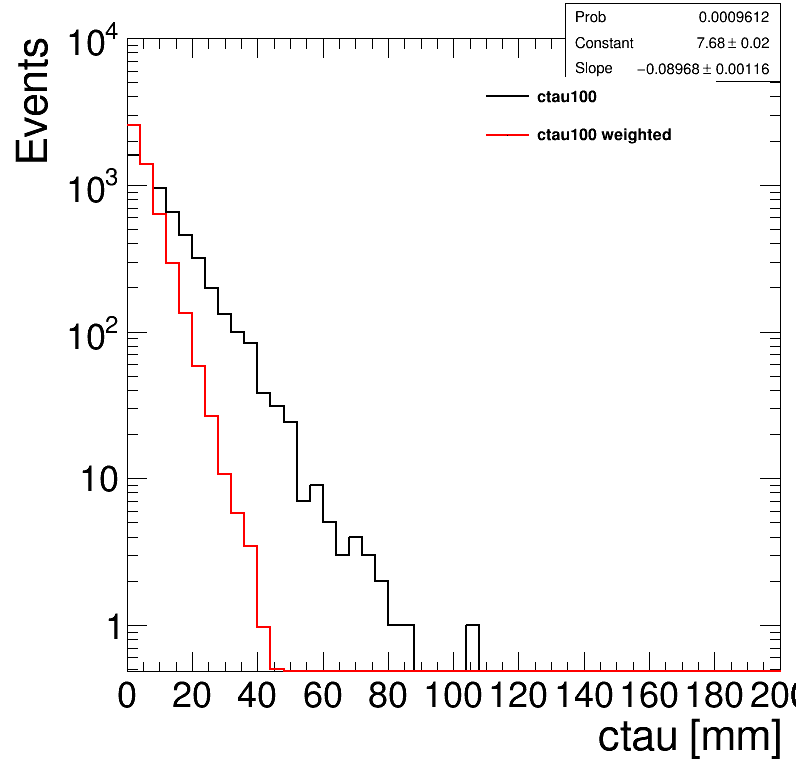

In [107]:

c = rt.TCanvas('c','c', 800, 800)
# h.SetStats(0)
leg = rt.TLegend(0.60,0.80,0.90,0.90)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
h = {}
rt.gStyle.SetOptFit(1011)

k = 'ctau100'
# bins = [50,0,1000]
# print(ctau[k].shape)
# h[k] = create_TH1D( ctau[k].flatten(), axis_title=['c#tau [cm]', 'Events'], name=k, binning=bins)
# w = np.transpose(np.vstack((weight[k],weight[k])))
# h[k+'weight'] = create_TH1D( ctau[k].flatten(), axis_title=['c#tau [cm]', 'Events'], name=k+'weight', binning=bins,weights = w.flatten())

# bins = [50,0,5000]
# h[k] = create_TH1D( gLLP_decay_vertex[k].flatten(), axis_title=['decay vertex [cm]', 'Events'], name=k, binning=bins)
# w = np.transpose(np.vstack((weight[k],weight[k])))
# h[k+'weight'] = create_TH1D( gLLP_decay_vertex[k].flatten(), axis_title=['decay vertex [cm]', 'Events'], name=k+'weight', binning=bins,weights = w.flatten())

bins = [50,0,200]
h[k] = create_TH1D( ctau_sum.flatten(), axis_title=['ctau [mm]', 'Events'], name=k, binning=bins)
w = np.transpose(np.vstack((weight_sum,weight_sum)))
print(len(w.flatten()), len(ctau_sum.flatten()))
h[k+'weight'] = create_TH1D( ctau_sum.flatten(), axis_title=['decay vertex [cm]', 'Events'], name=k+'weight', binning=bins,weights = w.flatten())
h[k].SetMaximum(10000)
# bins = [50,0,10000]
# h[k] = create_TH1D( gamma[k].flatten(), axis_title=['#gamma[cm]', 'Events'], name=k, binning=bins)
# w = np.transpose(np.vstack((weight[k],weight[k])))
# h[k+'weight'] = create_TH1D( gamma[k].flatten(), axis_title=['decay vertex [cm]', 'Events'], name=k+'weight', binning=bins,weights = w.flatten())



h[k].SetLineColor(std_color_list[0])
h[k+'weight'].SetLineColor(std_color_list[1])

leg.AddEntry(h[k], k)
leg.AddEntry(h[k+'weight'],k+' weighted')
# #     h[k].SetMinimum(1)
# h[k].GetXaxis().SetLabelSize(0.04)
r = h[k].Fit('expo', 'LRSQ+0', '', 0,1000)
print(r.Get())
print(r.Prob())
# h[k].GetFunction("expo").SetLineColor(std_color_list[0])
# h[k].GetFunction("expo").SetLineStyle(2)
# h[k].GetFunction("expo").SetLineWidth(2)
print('original ctau is: '+str(-1.0/r.Parameter(1)*10)+' mm')
h[k].Draw()
# h[k].GetFunction("expo").Delete()

r = h[k+'weight'].Fit('expo', 'LRSQ+0', 'a', 0,1000)
print(r.Get())
print(r.Prob())

print('new ctau is: '+str(-1.0/r.Parameter(1)*10)+' mm')
h[k+'weight'].Draw('same hist')


leg.Draw('same')
c.SetLogy()


c.Draw()

    
    


# c.Draw()
# print(time.time()-start_t)

[p8761zgjiop-+
# compare other variables

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: bbbb (Potential memory leak).


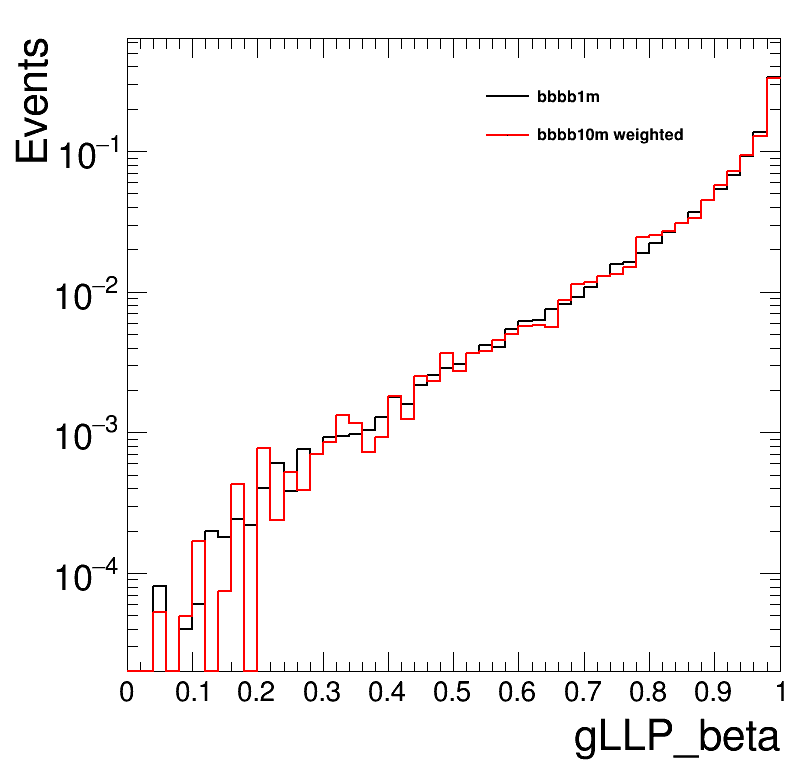

In [100]:
# Plotting ncsc
start_t = time.time()
c = rt.TCanvas('c','c', 1000, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.58,0.70,0.94,0.85)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)

i = 0
k = 'data_intime'

# h[k] = create_TH2D(np.column_stack((angle[k][cond],jetPt[k][cond][:,0])), axis_title = ['\Delta\phi (jet,met)','jet p_{T}[GeV]','Events'], binning=[80,-3.14,3.14,100,0,2000])
h[k] = create_TH2D(np.column_stack(( nCsc_JetMuonVetoCluster0p4_Me1112Veto[k], dphiMet_cluster[k])),
                   axis_title = ['N_{rechits}','\Delta\phi (cluster,met)','Events'], binning=[50,0,600,50,0,3.14])


h[k].GetXaxis().SetLabelSize(0.04)




h[k].SetLineColor(std_color_list[i])
# leg.AddEntry(h[k], k)
#     h[k].SetMaximum(10E5)
#     h[k].SetMinimum(1)
h[k].Draw('colz')
c.SetRightMargin(0.2)



# if setlog: 
c.SetLogz()
c.Draw()
print(time.time()-start_t)